In [250]:
import numpy as np
import pandas as pd
from obspy import read
import os
import matplotlib.pyplot as plt
import plotly.express as px
from geopy import distance
from scipy.fft import fft, ifft, fftfreq

# Data Cleaning

In [251]:
directory = "./sw4_test_output/"
obs_directory = "./obs_test_output/"

# station location data
locations = pd.read_csv('sw4_station.txt', delimiter = ",")

In [252]:
def create_df(directory, bandpass=False, bp_range=[0, 1]):
    """
    Creates pandas DataFrame from seismic data.
    
    Args:
        directory: The directory (string) where seismic data is located (containing .e, ,n. .u files)
    
    Returns:
        pandas DataFrame
    
    Raises:
        AssertionError: If there is an issue with the data files
    """
    # cleaning and putting all the sw4 seismic data into a DataFrame
    # .BH is removed (they are duplicate sensors)
    file_list = os.listdir(directory)
    file_list.sort()
    file_list = [x for x in file_list if "sw4img" not in x and ".dat" not in x and "BH" not in x and ".xml" not in x and ".sacpz" not in x]
    assert((len(file_list) / 3) - int(len(file_list) / 3) == 0)
    df = pd.DataFrame(data=file_list)
    df.columns = ['Point']
    
    # peak and duration data for each point
    absolute_peaks = []
    durations = []
    amplitudes = []
    times = []
    deltas = []
    for i in range(len(file_list)):
        st = read(directory+file_list[i])
        tr = st[0]
        if bandpass:
            tr.filter('bandpass', freqmin=bp_range[0], freqmax=bp_range[1], corners=2, zerophase=True)
        abs_data = abs(tr.data)
        time = tr.times()
        threshold = max(abs_data) * 0.1
        start = np.argmax(abs_data>threshold)
        data_flipped = np.flip(abs_data)
        end = len(abs_data) - np.argmax(data_flipped>threshold) - 1
        duration = time[end] - time[start]
        absolute_peaks.append(abs(max(tr.data, key=abs)))
        durations.append(duration)
        amplitudes.append(tr.data)
        times.append(tr.times())
        deltas.append(tr.stats['delta'])
        # test single point
        # set name of data point to name

        name = "" #"BK.BRK.HN.u"
        if file_list[i] == name:
            print('peak: ', abs(max(tr.data, key=abs)))
            print('duration: ', [time[start], time[end]])
            plt.plot(time, tr.data)
            plt.axvline(x=time[start], color='r')
            plt.axvline(x=time[end], color='r')   

    
    # full dataframe
    df["Station"] = [x[:-5] for x in df["Point"]]
    df["Amplitudes"] = amplitudes
    df["Times"] = times
    df["Absolute Peak"] = absolute_peaks
    df["Duration"] = durations
    df["Delta"] = deltas
    df_with_locations = pd.merge(df, locations, left_on='Station', right_on='net.sta')
    df_with_locations = df_with_locations.drop(columns=['net.sta'])
    source = (37.86119, -122.24233)
    df_with_locations['Distance (miles)'] = df_with_locations.apply(lambda row: distance.distance((row.lat, row.lon), source).miles, axis=1)
    return df_with_locations

In [253]:
sw4_df = create_df(directory)
sw4_df

,Point,Station,Amplitudes,Times,Absolute Peak,Duration,Delta,lat,lon,Distance (miles)
0,BK.BDM.HN.e,BK.BDM,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.03767897654, 0.0753579530799, 0.113036...",0.000380,54.144689,0.037679,37.953970,-121.86554,21.561090
1,BK.BDM.HN.n,BK.BDM,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[0.0, 0.03767897654, 0.0753579530799, 0.113036...",0.000315,69.366996,0.037679,37.953970,-121.86554,21.561090
2,BK.BDM.HN.u,BK.BDM,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[0.0, 0.03767897654, 0.0753579530799, 0.113036...",0.000358,54.596837,0.037679,37.953970,-121.86554,21.561090
3,BK.BKS.HN.e,BK.BKS,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.03767897654, 0.0753579530799, 0.113036...",0.001960,41.974380,0.037679,37.876220,-122.23558,1.100331
4,BK.BKS.HN.n,BK.BKS,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[0.0, 0.03767897654, 0.0753579530799, 0.113036...",0.001214,46.232104,0.037679,37.876220,-122.23558,1.100331
...,...,...,...,...,...,...,...,...,...,...
952,NP.ADS2.HN.n,NP.ADS2,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[0.0, 0.03767897654, 0.0753579530799, 0.113036...",0.000211,38.658630,0.037679,38.774460,-122.69974,67.717936
953,NP.ADS2.HN.u,NP.ADS2,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[0.0, 0.03767897654, 0.0753579530799, 0.113036...",0.000110,51.770914,0.037679,38.774460,-122.69974,67.717936
954,NP.PLA.HN.e,NP.PLA,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.03767897654, 0.0753579530799, 0.113036...",0.000247,64.204976,0.037679,37.798672,-121.46315,42.840388
955,NP.PLA.HN.n,NP.PLA,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[0.0, 0.03767897654, 0.0753579530799, 0.113036...",0.000639,44.837982,0.037679,37.798672,-121.46315,42.840388


In [254]:
obs_df = create_df(obs_directory)
obs_df

,Point,Station,Amplitudes,Times,Absolute Peak,Duration,Delta,lat,lon,Distance (miles)
0,BK.BDM.HN.e,BK.BDM,"[-5.11707e-07, -5.13278e-07, -5.15149e-07, -5....","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",0.001021,35.470,0.010,37.953970,-121.86554,21.561090
1,BK.BDM.HN.n,BK.BDM,"[-9.12081e-07, -9.13333e-07, -9.1607e-07, -9.1...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",0.001588,26.340,0.010,37.953970,-121.86554,21.561090
2,BK.BDM.HN.u,BK.BDM,"[2.55943e-07, 2.52683e-07, 2.51328e-07, 2.4788...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",0.000720,44.460,0.010,37.953970,-121.86554,21.561090
3,BK.BKS.HN.e,BK.BKS,"[-9.41834e-07, -9.44314e-07, -9.48473e-07, -9....","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",0.004232,15.220,0.010,37.876220,-122.23558,1.100331
4,BK.BKS.HN.n,BK.BKS,"[3.26108e-07, 3.30227e-07, 3.30789e-07, 3.3475...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",0.002665,20.810,0.010,37.876220,-122.23558,1.100331
...,...,...,...,...,...,...,...,...,...,...
890,NP.ADS2.HN.n,NP.ADS2,"[-1.61606e-05, -1.61772e-05, -1.61948e-05, -1....","[0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0...",0.000081,224.630,0.005,38.774460,-122.69974,67.717936
891,NP.ADS2.HN.u,NP.ADS2,"[-6.87644e-06, -6.88696e-06, -6.89823e-06, -6....","[0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0...",0.000112,219.750,0.005,38.774460,-122.69974,67.717936
892,NP.PLA.HN.e,NP.PLA,"[-2.47454e-06, -2.47874e-06, -2.48279e-06, -2....","[0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0...",0.000886,78.415,0.005,37.798672,-121.46315,42.840388
893,NP.PLA.HN.n,NP.PLA,"[2.22126e-06, 2.22438e-06, 2.22774e-06, 2.2313...","[0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0...",0.000887,82.055,0.005,37.798672,-121.46315,42.840388


# Visualizing Peaks and Duration for Each Direction

In [262]:
# only .e
east_west = sw4_df.iloc[::3, :]
obs_east_west = obs_df[obs_df['Point'].str.contains(r'.e')]
east_west = east_west[east_west['Point'].isin(obs_east_west['Point'])]
east_west.reset_index(inplace=True, drop=True)
obs_east_west.reset_index(inplace=True, drop=True)
# only .n
north_south = sw4_df.iloc[1::3, :]
obs_east_west = obs_df[obs_df['Point'].str.contains(r'.n')]
north_south = north_south[north_south['Point'].isin(obs_north_south['Point'])]
north_south.reset_index(inplace=True, drop=True)
obs_north_south.reset_index(inplace=True, drop=True)
# only .u
up_down = sw4_df.iloc[2::3, :]
obs_up_down = obs_df[obs_df['Point'].str.contains(r'.u')]
up_down = up_down[up_down['Point'].isin(obs_up_down['Point'])]
up_down.reset_index(inplace=True, drop=True)
obs_up_down.reset_index(inplace=True, drop=True)

In [263]:
ew = px.scatter_mapbox(east_west, lat='lat', lon='lon', color='Absolute Peak', hover_name='Station', mapbox_style='stamen-terrain', color_continuous_scale = 
                'rainbow', range_color=(0,0.003), title="{SW4} Peak Amplitude at Each Individual Station (East-West)")
ew.update_traces(marker={'size': 8})
ew.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
ew.show()

obs_ew = px.scatter_mapbox(obs_east_west, lat='lat', lon='lon', color='Absolute Peak', hover_name='Station', mapbox_style='stamen-terrain', color_continuous_scale = 
                'rainbow', range_color=(0,0.003), title="{OBSERVED} Peak Amplitude at Each Individual Station (East-West)")
obs_ew.update_traces(marker={'size': 8})
obs_ew.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
obs_ew.show()

In [264]:
ns = px.scatter_mapbox(north_south, lat='lat', lon='lon', color='Absolute Peak', hover_name='Station', mapbox_style='stamen-terrain', color_continuous_scale = 
                'rainbow', range_color=(0,0.003), title="{SW4} Peak Amplitude at Each Individual Station (North-South)")
ns.update_traces(marker={'size': 8})

ns.show()

obs_ns = px.scatter_mapbox(obs_north_south, lat='lat', lon='lon', color='Absolute Peak', hover_name='Station', mapbox_style='stamen-terrain', color_continuous_scale = 
                'rainbow', range_color=(0,0.003), title="{OBSERVED} Peak Amplitude at Each Individual Station (North-South)")
obs_ns.update_traces(marker={'size': 8})

obs_ns.show()

In [265]:
ud = px.scatter_mapbox(up_down, lat='lat', lon='lon', color='Absolute Peak', hover_name='Station', mapbox_style='stamen-terrain', color_continuous_scale = 
                'rainbow', range_color=(0, 0.003), title="{SW4} Peak Amplitude at Each Individual Station (Up-Down)")
ud.update_traces(marker={'size': 8})

ud.show()

obs_ud = px.scatter_mapbox(obs_up_down, lat='lat', lon='lon', color='Absolute Peak', hover_name='Station', mapbox_style='stamen-terrain', color_continuous_scale = 
                'rainbow', range_color=(0, 0.003), title="{OBSERVED} Peak Amplitude at Each Individual Station (Up-Down)")
obs_ud.update_traces(marker={'size': 8})

obs_ud.show()

There does not seem to be major differences between each direction within each dataset, although the east-west peaks seem to be on average higher than the other directions in the San Franciso area for the sw4 data. I believe we can safely take the magnitude of all 3 points and use 3D-vector data to do our analysis.

However, when you compare the sw4 data with the observed data, you can clearly see that the observed data has significantly higher amplitudes than what is generated by the model.

In [266]:
ew = px.scatter_mapbox(east_west, lat='lat', lon='lon', color='Duration', hover_name='Station', mapbox_style='stamen-terrain', color_continuous_scale = 
                'rainbow', range_color=(0,200), title="{SW4} Duration at Each Individual Station (East-West)")
ew.update_traces(marker={'size': 8})
ew.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
ew.show()

obs_ew = px.scatter_mapbox(obs_east_west, lat='lat', lon='lon', color='Duration', hover_name='Station', mapbox_style='stamen-terrain', color_continuous_scale = 
                'rainbow', range_color=(0,200), title="{OBSERVED} Duration at Each Individual Station (East-West)")
obs_ew.update_traces(marker={'size': 8})
obs_ew.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
obs_ew.show()

In [267]:
ns = px.scatter_mapbox(north_south, lat='lat', lon='lon', color='Duration', hover_name='Station', mapbox_style='stamen-terrain', color_continuous_scale = 
                'rainbow', range_color=(0,200), title="{SW4} Duration at Each Individual Station (North-South)")
ns.update_traces(marker={'size': 8})
ns.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
ns.show()

obs_ns = px.scatter_mapbox(obs_north_south, lat='lat', lon='lon', color='Duration', hover_name='Station', mapbox_style='stamen-terrain', color_continuous_scale = 
                'rainbow', range_color=(0,200), title="{OBSERVED} Duration at Each Individual Station (North-South)")
obs_ns.update_traces(marker={'size': 8})
obs_ns.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
obs_ns.show()

In [269]:
ud = px.scatter_mapbox(up_down, lat='lat', lon='lon', color='Duration', hover_name='Station', mapbox_style='stamen-terrain', color_continuous_scale = 
                'rainbow', range_color=(0,200), title="{SW4} Duration at Each Individual Station (Up-Down)")
ud.update_traces(marker={'size': 8})
ud.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
ud.show()

obs_ud = px.scatter_mapbox(obs_up_down, lat='lat', lon='lon', color='Duration', hover_name='Station', mapbox_style='stamen-terrain', color_continuous_scale = 
                'rainbow', range_color=(0,200), title="{OBSERVED} Duration at Each Individual Station (Up-Down)")
obs_ud.update_traces(marker={'size': 8})
obs_ud.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
obs_ud.show()

As you would probably expect after seeing the previous amplitude plots, the durations generated by sw4 are also much shorter than the observed data.

# Visualizing as 3D Vector Data

In [270]:
def create_df_3d(directory, bandpass=False, bp_range=[0, 1]):
    """
    Creates pandas DataFrame from seismic data using total magnitude of all directions.
    
    Args:
        directory: The directory (string) where seismic data is located (containing .e, ,n. .u files)
        bandpass: Boolean denoting whether or not there is a band-pass filter applied.
        bp_range: List for the range of frequencies (between 0 and 1) for the band pass filter 
    
    Returns:
        pandas DataFrame
    
    Raises:
        AssertionError: If there is an issue with the data files   
    """
    file_list = os.listdir(directory)
    file_list.sort()
    file_list = [x for x in file_list if "sw4img" not in x and ".dat" not in x and "BH" not in x and ".xml" not in x and ".sacpz" not in x]
    assert((len(file_list) / 3) - int(len(file_list) / 3) == 0)
    
    # creating 3D Vector Data
    magnitudes = []
    durations = []
    peaks = []
    for i in range(0, len(file_list), 3):
        st = read(directory+file_list[i])
        tr_e = st[0]
        if bandpass:
            tr_e.filter('bandpass', freqmin=bp_range[0], freqmax=bp_range[1], corners=2, zerophase=True)
        x = tr_e.data
        st = read(directory+file_list[i+1])
        tr_n = st[0]
        if bandpass:
            tr_n.filter('bandpass', freqmin=bp_range[0], freqmax=bp_range[1], corners=2, zerophase=True)
        y = tr_n.data
        st = read(directory+file_list[i+2])
        tr_u = st[0]
        if bandpass:
            tr_u.filter('bandpass', freqmin=bp_range[0], freqmax=bp_range[1], corners=2, zerophase=True)
        z = tr_u.data
        length = min(len(x), len(y), len(z))
        mag = np.sqrt(x[:length]**2 + y[:length]**2 + z[:length]**2)
        threshold = max(mag) * 0.1
        start = np.argmax(mag>threshold)
        mag_flipped = np.flip(mag)
        end = len(mag) - np.argmax(mag_flipped>threshold) - 1
        time = tr_u.times()
        peak = max(mag)
        duration = time[end] - time[start]
        durations.append(duration)
        magnitudes.append(mag)
        peaks.append(peak)

        # test single point
        # set name of data point to name
        
        name = ""#"BK.BKS.HN"
        if file_list[i][:-2] == name:
            print(file_list[i][:-2])
            plt.plot(time, mag)
            plt.axvline(x=time[start], color='r')
            plt.axvline(x=time[end], color='r')
            print('duration: ', [time[start], time[end]])
        
    
    # new DataFrame for 3D Data
    new_points = file_list[::3]
    new_points = [x[:-2] for x in new_points]
    df_3d = pd.DataFrame(data=new_points)
    df_3d.columns = ['Point']
    df_3d["Station"] = [x[:-3] for x in df_3d["Point"]]
    df_3d["Magnitudes"] = magnitudes
    df_3d["Peak"] = peaks
    df_3d["Duration"] = durations
    df_3d = pd.merge(df_3d, locations, left_on='Station', right_on='net.sta')
    df_3d = df_3d.drop(columns=['net.sta'])
    df_3d = df_3d.drop_duplicates(subset = ["Station"])
    return df_3d

In [271]:
sw4_df_3d = create_df_3d(directory)

In [296]:
obs_df_3d = create_df_3d(obs_directory)
sw4_df_3d = sw4_df_3d[sw4_df_3d['Point'].isin(obs_df_3d['Point'])]
obs_df_3d = obs_df_3d[obs_df_3d['Point'].isin(sw4_df_3d['Point'])]
sw4_df_3d.reset_index(inplace=True, drop=True)
obs_df_3d.reset_index(inplace=True, drop=True)

In [273]:
fig1 = px.scatter_mapbox(sw4_df_3d, lat='lat', lon='lon', color='Peak', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow', range_color=(0, 0.003),
                         title="{SW4} Peak Amplitude (Using 3D Vector Data) at Each Individual Station")
fig1.update_traces(marker={'size': 8})
fig1.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
fig1.show()

obs_fig1 = px.scatter_mapbox(obs_df_3d, lat='lat', lon='lon', color='Peak', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow', range_color=(0, 0.003),
                         title="{OBSERVED} Peak Amplitude (Using 3D Vector Data) at Each Individual Station")
obs_fig1.update_traces(marker={'size': 8})
obs_fig1.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
obs_fig1.show()

In [274]:
fig2 = px.scatter_mapbox(sw4_df_3d, lat='lat', lon='lon', color='Duration', mapbox_style='stamen-terrain', hover_name='Station', color_continuous_scale = 
                'rainbow', range_color=(0, 200), title="{SW4} Duration of Earthquake (Using 3D Vector Data) at Each Individual Station")
fig2.update_traces(marker={'size': 8})
fig2.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
fig2.show()

obs_fig2 = px.scatter_mapbox(obs_df_3d, lat='lat', lon='lon', color='Duration', mapbox_style='stamen-terrain', hover_name='Station', color_continuous_scale = 
                'rainbow', range_color=(0, 200), title="{OBSERVED} Duration of Earthquake (Using 3D Vector Data) at Each Individual Station")
obs_fig2.update_traces(marker={'size': 8})
obs_fig2.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
obs_fig2.show()

Peak amplitude definitely shows a trend of decreasing as we move away from the source of the earthquake, duration seem to be determined by the terrain.

Again though, the observed data is pretty drastically different from the sw4 output.

# Plotting Peak Amplitude/Duration Vs Distance

In [275]:
source = (37.86119, -122.24233)
sw4_df_3d['Distance (miles)'] = sw4_df_3d.apply(lambda row: distance.distance((row.lat, row.lon), source).miles, axis=1)
fig = px.scatter(sw4_df_3d, x = 'Distance (miles)', y = 'Peak', title = "{SW4} Peak Magnitude (3D Vector) vs Distance");
fig.show()

In [276]:
fig = px.scatter(sw4_df_3d, x ='Distance (miles)', y ='Duration', title = "{SW4} Duration vs Distance", color_discrete_sequence=['red']);
fig.show()

In [277]:
obs_df_3d['Distance (miles)'] = obs_df_3d.apply(
    lambda row: distance.distance((row.lat, row.lon), source).miles, axis=1)
fig = px.scatter(obs_df_3d, x = 'Distance (miles)', y = 'Peak', title = "{OBSERVED} Peak Magnitude (3D Vector) vs Distance");
fig.update_yaxes(range=[0, 0.04])
fig.show()
# note - there is one very far outlier at about ~65 miles if you rescale

In [278]:
fig = px.scatter(obs_df_3d, x = 'Distance (miles)', y = 'Duration', title = "{OBSERVED} Duration vs Distance", color_discrete_sequence=['red']);
fig.update_yaxes(range=[0, 120])
fig.show()

Definitely a more interesting trend going on for the observed data here. Distance seems to not correlate with the duration, but there are certain areas where the duration is almost exactly the same (possibly along a line on the map). Or our method of computing duration just does not work for the observed data.

# Comparing Data Points

Here we compare NC.C033 and BK.BRK, because from the peak amplitude geographic plot it seems like BK.BRK is a very small value, even though it is about the same distance (very close) to the source. There could be an error in our computation.

In [279]:
def compare(point1, point2, freq_range_displayed=[0, 2.5]):
    """
    Plots out graphs for two different points you want to compare.
    
    Args:
    point1: [name, table]; name=Name of data point, table=pandas DataFrame where data point comes from
    point2: [name, table]
    
    Returns:
        None, just plots
    """
    df1 = point1[1]
    df1 = df1.set_index('Point')
    point1 = point1[0]
    df2 = point2[1]
    df2 = df2.set_index('Point')
    point2 = point2[0]
    
    T1 = df1.loc[point1]['Delta']
    T2 = df2.loc[point2]['Delta']

    data1 = df1.loc[point1]['Amplitudes']
    times1 = df1.loc[point1]['Times']
    data2 = df2.loc[point2]['Amplitudes']
    times2 = df2.loc[point2]['Times']
    
    plt.figure(0)
    plt.plot(times1, data1)
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.title(point1);

    plt.figure(1)
    plt.plot(times2, data2, color='orange')
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.title(point2);
    
    plt.figure(2)
    plt.plot(times1, data1)
    plt.plot(times2, data2, color='orange')
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.title(point2);
    
    # For Fourier Transform, can do other visualizations
    N = len(data1)
    yf = fft(data1)
    xf = fftfreq(N, T1)[:N//2]
    yf = 2.0/N * np.abs(yf[0:N//2])
    plt.figure(3)
    plt.plot(xf, yf, label='point1')
    
    N = len(data2)
    yf = fft(data2)
    xf = fftfreq(N, T2)[:N//2]
    yf = 2.0/N * np.abs(yf[0:N//2])
    plt.figure(3)
    plt.plot(xf, yf, label='point2')
    
    plt.grid()
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency (Hz)");
    plt.xlim(freq_range_displayed)
    plt.title(point1 + ', ' + point2);
    plt.legend()

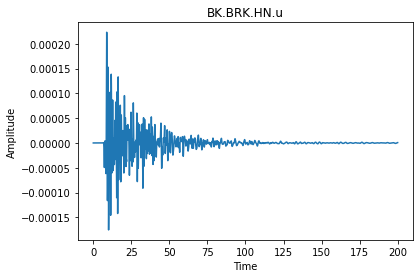

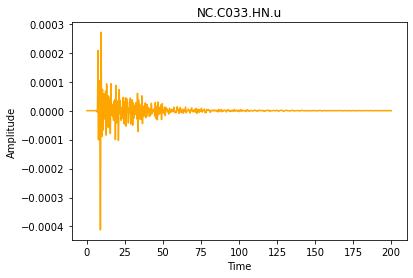

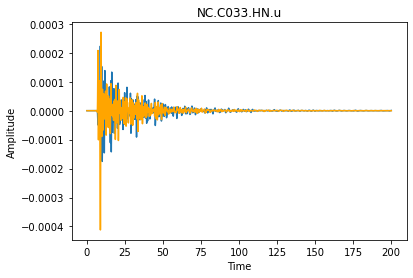

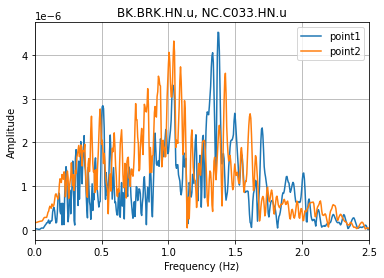

In [280]:
compare(['BK.BRK.HN.u', sw4_df], ['NC.C033.HN.u', sw4_df])

It seems like NC.C033 really does have a higher peak (it is very extreme at the start). BK.BRK actually has relatively low amplitudes despite being so close to the source, which is interesting. We will know if the model is accurate in simulating this once we have the true data.

In [248]:
compare(['NC.JBR.HN.e', sw4_df], ['NC.JBR.HN.e', obs_df])


,Point,Station,Amplitudes,Times,Absolute Peak,Duration,Delta,lat,lon,Distance (miles)
0,BK.BDM.HN.u,BK.BDM,"[6.27309142259e-07, 6.28802505748e-07, 6.30288...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",0.000014,373.240,0.010,37.953970,-121.865540,21.561090
1,BK.BKS.HN.u,BK.BKS,"[1.59603643674e-07, 1.52208516562e-07, 1.44803...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",0.000007,378.050,0.010,37.876220,-122.235580,1.100331
2,BK.BL67.HN.u,BK.BL67,"[-8.26971626505e-08, -5.10016652455e-08, -1.92...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",0.000010,388.450,0.010,37.874920,-122.243180,0.948077
3,BK.BL88.HN.u,BK.BL88,"[1.04671030632e-07, 4.89413762959e-08, -6.8948...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",0.000013,388.510,0.010,37.877150,-122.254290,1.280312
4,BK.BRK.HN.u,BK.BRK,"[2.88232843263e-07, 3.40663362127e-07, 3.93177...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",0.000025,373.020,0.010,37.873520,-122.260990,1.328163
...,...,...,...,...,...,...,...,...,...,...
292,NP.1861.HN.u,NP.1861,"[3.1140929411e-06, 3.09406939864e-06, 3.073999...","[0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0...",0.000093,204.260,0.005,37.792070,-122.263760,4.909100
293,NP.1862.HN.u,NP.1862,"[4.84115563646e-06, 4.90784307698e-06, 4.97462...","[0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0...",0.000031,214.585,0.005,37.299500,-122.084900,39.688986
294,NP.1863.HN.u,NP.1863,"[1.88723922244e-06, 1.65567212956e-06, 1.42370...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...",0.000040,389.000,0.010,37.666656,-121.857147,24.995064
295,NP.ADS2.HN.u,NP.ADS2,"[-2.95382214178e-06, -2.971370048e-06, -2.9888...","[0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0...",0.000035,223.560,0.005,38.774460,-122.699740,67.717936


Way different even though it is the same point.

# Frequency Analysis

In [281]:
indexed = sw4_df.set_index('Point')
frequency_table = []
Corr_Amp = []
for i in sw4_df.Point:  
    data = indexed.loc[i]['Amplitudes']
    T = indexed.loc[i]['Delta']
    N = len(data)
    yf = fft(data)
    xf = fftfreq(N, T)[:N//2]
    yf = 2.0/N * np.abs(yf[0:N//2])
    peak_amp_at = np.argmax(yf)
    frequency = xf[peak_amp_at]
    amp = yf[peak_amp_at]
    point = (frequency, amp)

    peak_amp_at2 = np.argsort(yf, axis=0)[-2]
    frequency2 = xf[peak_amp_at2]
    amp2 = yf[peak_amp_at2]
    point2 = (frequency2, amp2)

    highest_points = pd.DataFrame([point, point2])
    firstfreq = highest_points.min()[0]
    frequency_table.append(firstfreq)
    amplification = highest_points.min()[1]
    Corr_Amp.append(amplification)
    
    
sw4_df["Frequency"] = frequency_table 
sw4_df["Corr_Amp"] = Corr_Amp

sw4_df_u = sw4_df[sw4_df.Point.str.contains('.u')]
sw4_df_n = sw4_df[sw4_df.Point.str.contains('.n')]
sw4_df_e = sw4_df[sw4_df.Point.str.contains('.e')]

In [282]:
fig = px.scatter(sw4_df_e, x='Distance (miles)', y='Frequency', hover_data=['Point'])
fig.show()
fig_e = px.scatter_mapbox(sw4_df_e, lat='lat', lon='lon', color='Frequency', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow', 
                         title="Frequency Value of Peak Amplitude at Each Individual Station (East-West)")
fig_e.update_traces(marker={'size': 8})
fig_e.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
fig_e.show();

In [283]:
fig = px.scatter(sw4_df_n, x='Distance (miles)', y='Frequency', hover_data=['Point'])
fig.show()
fig_n = px.scatter_mapbox(sw4_df_n, lat='lat', lon='lon', color='Frequency', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow', 
                         title="Frequency Value of Peak Amplitude at Each Individual Station (North-South)")
fig_n.update_traces(marker={'size': 8})
fig_n.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
fig_n.show()

In [284]:
fig = px.scatter(sw4_df_u, x='Distance (miles)', y='Frequency', hover_data=['Point'])
fig.show()
fig_u = px.scatter_mapbox(sw4_df_u, lat='lat', lon='lon', color='Frequency', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow', 
                         title="Frequency Value of Peak Amplitude at Each Individual Station (Up-Down)")
fig_u.update_traces(marker={'size': 8})
fig_u.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
fig_u.show()

In [285]:
df_3d_bp = create_df_3d(directory, True, [0.2, 0.5])

In [286]:
df_3d_bp1 = create_df_3d(directory, True, [0.5, 1])

In [287]:
fig1 = px.scatter_mapbox(df_3d_bp, lat='lat', lon='lon', color='Peak', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow', range_color=(0, 0.002),
                         title="{SW4} Peak Amplitude (Using Band-Passed [0.2-0.5] 3D Vector Data) at Each Individual Station")
fig1.update_traces(marker={'size': 8})
fig1.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
fig1.show()

In [288]:
fig2 = px.scatter_mapbox(df_3d_bp1, lat='lat', lon='lon', color='Peak', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow', range_color=(0, 0.002),
                         title="{SW4} Peak Amplitude (Using Band-Passed [0.5-1.0] 3D Vector Data) at Each Individual Station")
fig2.update_traces(marker={'size': 8})
fig2.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
fig2.show()

# Playing with Different Scales

In [318]:
# synthetic/ observation
def plot_peak_ratio(synthetic_table, observed_table, peak_type='Peak'):
    df = observed_table.copy()
    df['Peak Ratio'] = np.true_divide(synthetic_table[peak_type], observed_table[peak_type])
    fig2 = px.scatter_mapbox(df, lat='lat', lon='lon', color='Peak Ratio', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow', range_color=(0, 2),
                         title="{SW4} Peak Amplitude Ratio Between SW4 and Observed Data (synthetic/observed) at Each Individual Station")
    fig2.update_traces(marker={'size': 8})
    fig2.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
    fig2.show()

In [298]:
sw4_df_3d
peak_df = sw4_df_3d[["Peak"]]
new_df = (peak_df-peak_df.min()) / (peak_df.max()-peak_df.min())
new_df2 = (peak_df-peak_df.mean())/peak_df.std()
sw4_df_3d['Peak 0-1'] = new_df
sw4_df_3d['Peak z-score'] = new_df2
sw4_df_3d

,Point,Station,Magnitudes,Peak,Duration,lat,lon,Distance (miles),Peak 0-1,Peak z-score
0,BK.BDM.HN,BK.BDM,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000469,69.404675,37.953970,-121.865540,21.561090,0.063158,-0.740471
1,BK.BKS.HN,BK.BKS,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.002302,41.861343,37.876220,-122.235580,1.100331,0.420038,1.018466
2,BK.BL67.HN,BK.BL67,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001931,40.919369,37.874920,-122.243180,0.948077,0.347904,0.662942
3,BK.BL88.HN,BK.BL88,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001272,41.333837,37.877150,-122.254290,1.280312,0.219485,0.030010
4,BK.BRK.HN,BK.BRK,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001455,31.047477,37.873520,-122.260990,1.328163,0.255154,0.205809
...,...,...,...,...,...,...,...,...,...,...
290,NP.1861.HN,NP.1861,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.004934,2.938960,37.792070,-122.263760,4.909100,0.932339,3.543418
291,NP.1862.HN,NP.1862,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000335,57.498118,37.299500,-122.084900,39.688986,0.037072,-0.869041
292,NP.1863.HN,NP.1863,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001005,58.289377,37.666656,-121.857147,24.995064,0.167552,-0.225947
293,NP.ADS2.HN,NP.ADS2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000267,53.014320,38.774460,-122.699740,67.717936,0.023814,-0.934382


In [299]:
peak_df = obs_df_3d[["Peak"]]
new_df = (peak_df-peak_df.min()) / (peak_df.max()-peak_df.min())
new_df2 = (peak_df-peak_df.mean())/peak_df.std()
obs_df_3d['Peak 0-1'] = new_df
obs_df_3d['Peak z-score'] = new_df2
obs_df_3d

,Point,Station,Magnitudes,Peak,Duration,lat,lon,Peak 0-1,Peak z-score
0,BK.BDM.HN,BK.BDM,"[1.07668e-06, 1.07772e-06, 1.08061e-06, 1.0815...",0.001627,35.750,37.953970,-121.865540,0.005120,-0.457625
1,BK.BKS.HN,BK.BKS,"[1.60992e-06, 1.6149e-06, 1.62033e-06, 1.62513...",0.004559,15.600,37.876220,-122.235580,0.015257,-0.300966
2,BK.BL67.HN,BK.BL67,"[7.59429e-06, 7.61724e-06, 7.64083e-06, 7.6622...",0.014106,5.270,37.874920,-122.243180,0.048257,0.209068
3,BK.BL88.HN,BK.BL88,"[1.50498e-05, 1.50837e-05, 1.51198e-05, 1.5152...",0.015586,10.640,37.877150,-122.254290,0.053373,0.288136
4,BK.BRK.HN,BK.BRK,"[9.25325e-06, 9.27872e-06, 9.3065e-06, 9.33084...",0.006933,8.330,37.873520,-122.260990,0.023462,-0.174150
...,...,...,...,...,...,...,...,...,...
290,NP.1861.HN,NP.1861,"[1.92613e-05, 1.92922e-05, 1.93236e-05, 1.9356...",0.023258,24.745,37.792070,-122.263760,0.079891,0.697975
291,NP.1862.HN,NP.1862,"[1.82559e-05, 1.82886e-05, 1.83209e-05, 1.8355...",0.003924,19.130,37.299500,-122.084900,0.013061,-0.334895
292,NP.1863.HN,NP.1863,"[4.17703e-05, 4.18879e-05, 4.20151e-05, 4.2135...",0.002326,47.190,37.666656,-121.857147,0.007535,-0.420303
293,NP.ADS2.HN,NP.ADS2,"[1.80195e-05, 1.80402e-05, 1.80625e-05, 1.8085...",0.000146,224.630,38.774460,-122.699740,0.000000,-0.536758


In [300]:
fig1 = px.scatter_mapbox(sw4_df_3d, lat='lat', lon='lon', color='Peak z-score', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow', range_color=(-1, 4),
                         title="{SW4} Peak Amplitude (Using 3D Vector Data) [Normalized using z-score] at Each Individual Station")
fig1.update_traces(marker={'size': 8})
fig1.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
fig1.show()

obs_fig1 = px.scatter_mapbox(obs_df_3d, lat='lat', lon='lon', color='Peak z-score', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow', range_color=(-1, 4),
                         title="{OBSERVED} Peak Amplitude (Using 3D Vector Data) [Normalized using z-score] at Each Individual Station")
obs_fig1.update_traces(marker={'size': 8})
obs_fig1.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
obs_fig1.show()

In [301]:
plot_peak_ratio(sw4_df_3d, obs_df_3d, 'Peak z-score')

In [302]:
fig1 = px.scatter_mapbox(sw4_df_3d, lat='lat', lon='lon', color='Peak 0-1', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow',
                         title="{SW4} Peak Amplitude (Using 3D Vector Data) [Normalized between 0-1] at Each Individual Station")
fig1.update_traces(marker={'size': 8})
fig1.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
fig1.show()

obs_fig1 = px.scatter_mapbox(obs_df_3d, lat='lat', lon='lon', color='Peak 0-1', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow',
                         title="{OBSERVED} Peak Amplitude (Using 3D Vector Data) [Normalized between 0-1] at Each Individual Station")
obs_fig1.update_traces(marker={'size': 8})
obs_fig1.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
obs_fig1.show()

In [303]:
plot_peak_ratio(sw4_df_3d, obs_df_3d, 'Peak 0-1')

# Band Pass

In [312]:
df_obs_band_passed = create_df(obs_directory, True, [0.03, 0.25])
df_sw4_band_passed = create_df(directory, True, [0.03, 0.25])
# 0.1-0.3 Hz
# .2-.5
# .4-.8
# .5-1


In [313]:
# only .e
east_west = df_sw4_band_passed[df_sw4_band_passed['Point'].str.contains(r'.e')]
obs_east_west = df_obs_band_passed[df_obs_band_passed['Point'].str.contains(r'.e')]
east_west = east_west[east_west['Point'].isin(obs_east_west['Point'])]
east_west.reset_index(inplace=True, drop=True)
obs_east_west.reset_index(inplace=True, drop=True)
# only .n
north_south = df_sw4_band_passed[df_sw4_band_passed['Point'].str.contains(r'.n')]
obs_north_south = df_obs_band_passed[df_obs_band_passed['Point'].str.contains(r'.n')]
north_south = north_south[north_south['Point'].isin(obs_north_south['Point'])]
north_south.reset_index(inplace=True, drop=True)
obs_north_south.reset_index(inplace=True, drop=True)
# only .u
up_down = df_sw4_band_passed[df_sw4_band_passed['Point'].str.contains(r'.u')]
obs_up_down = df_obs_band_passed[df_obs_band_passed['Point'].str.contains(r'.u')]
up_down = up_down[up_down['Point'].isin(obs_up_down['Point'])]
up_down.reset_index(inplace=True, drop=True)
obs_up_down.reset_index(inplace=True, drop=True)

In [319]:
dff = up_down
obs_dff = obs_up_down


fig1 = px.scatter_mapbox(dff, lat='lat', lon='lon', color='Absolute Peak', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow', range_color=(0, 0.000001 *140),
                         title="{SW4} Peak Amplitude at Each Individual Station")
fig1.update_traces(marker={'size': 8})
fig1.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
fig1.show()

obs_fig1 = px.scatter_mapbox(obs_dff, lat='lat', lon='lon', color='Absolute Peak', hover_name='Station', 
                         mapbox_style='stamen-terrain', color_continuous_scale = 
                        'rainbow', range_color=(0, 0.000001 *140),
                         title="{OBSERVED} Peak Amplitude at Each Individual Station")
obs_fig1.update_traces(marker={'size': 8})
obs_fig1.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
obs_fig1.show()

In [320]:
fig2 = px.scatter_mapbox(dff, lat='lat', lon='lon', color='Duration', mapbox_style='stamen-terrain', hover_name='Station', color_continuous_scale = 
                'rainbow', range_color=(0, 150), title="{SW4} Duration of Earthquake at Each Individual Station")
fig2.update_traces(marker={'size': 8})
fig2.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
fig2.show()

obs_fig2 = px.scatter_mapbox(obs_dff, lat='lat', lon='lon', color='Duration', mapbox_style='stamen-terrain', hover_name='Station', color_continuous_scale = 
                'rainbow', range_color=(0, 150), title="{OBSERVED} Duration of Earthquake at Each Individual Station")
obs_fig2.update_traces(marker={'size': 8})
obs_fig2.add_scattermapbox(lat=[37.86119], lon=[-122.24233], 
                     hovertemplate = 'SOURCE',
                     marker_size = 15,
                     marker_color = 'pink',
                     showlegend = False
                     )
obs_fig2.show()

In [321]:
plot_peak_ratio(dff, obs_dff, 'Absolute Peak')

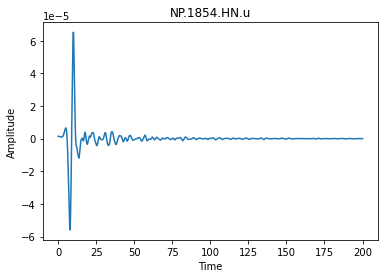

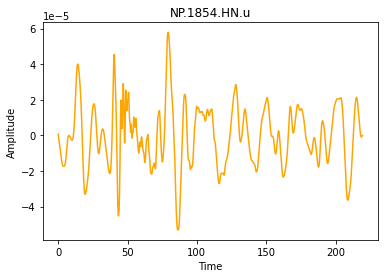

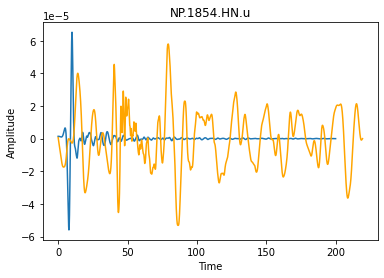

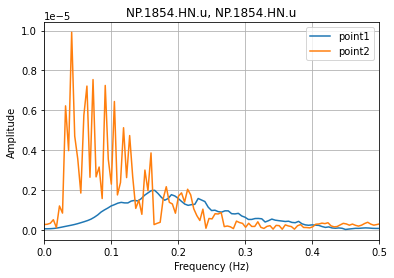

In [322]:
compare(['NP.1854.HN.u', dff], ['NP.1854.HN.u', obs_dff], [0, 0.5])

# END


In [239]:
def add_new_columns(df, is_sw4=False):

    peak_df = df[["Peak"]].copy()
    new_df = (peak_df-peak_df.min()) / (peak_df.max()-peak_df.min())
    new_df2 = (peak_df-peak_df.mean())/peak_df.std()
    df['Peak 0-1'] = new_df
    df['Peak z-score'] = new_df2
    return df